In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal
from scipy.signal import convolve
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader

In [2]:
def findGradient(img, ksize=5, sigma=1):
    G = cv2.getGaussianKernel(ksize, sigma)
    G = G @ G.T
    fx = np.array([[1, -1]])
    fy = fx.T
    Gx = scipy.signal.convolve2d(G, fx, 'same', 'symm')[:, 1:]
    Gy = scipy.signal.convolve2d(G, fy, 'same', 'symm')[1:, :]
    Ix = scipy.signal.convolve2d(img, Gx, 'same', 'symm')
    Iy = scipy.signal.convolve2d(img, Gy, 'same', 'symm')
    return Ix, Iy

In [3]:
def select_win(lst, slice1, slice2):
    return [item[slice1, slice2] for item in lst]

This week we talked about Lucas-Kanade method to estimate the optical flow. Given two images I and J, we'd like to find a 2d displacement d = (u, v)

such that 

$$||J(x+u, y+v) - I(x, y)||^2$$

is minimized. 

When d is small, we can linearize it with Taylor Expansion

$$ J(x+u, y+v) \approx J(x, y) + \frac{\partial{J}}{\partial{x}}u + \frac{\partial{J}}{\partial{y}}v $$




$\frac{\partial{J}}{\partial{x}}$ is just the x gradient of J image, let's use $J_x$ to stand for it. Then our goal can be rewritten as 




$$||\begin{bmatrix} J_x & J_y \end{bmatrix} \begin{bmatrix} u \\ v \end{bmatrix} -(I(x, y) - J(x, y))||^2$$

Only one corresondence can't give us a lot information. If we assume over a small window (for instance, 5 by 5) all pixels have the same movement d = (u, v) and stack them together

$$ || \begin{bmatrix} J_x(p_1) & J_y(p_1)\\ J_x(p_2) & J_y(p_2)\\ \vdots & \vdots\\ J_x(p_{25}) & J_y(p_{25}) \end{bmatrix} \begin{bmatrix} u \\ v \end{bmatrix} - \begin{bmatrix} I(p_1)-J(p_1)\\ I(p_2)-J(p_2)\\ \vdots\\ I(p_{25})-J(p_{25}) \end{bmatrix} ||^2 $$


This is in the form of least squares problem $$||Ax - b||^2$$ The close-form solution to this minimization problem is 
$$x = (A^T A)^{-1}A^T b$$
To get the solution x, we can also solve for the equation (known as the normal equation)
$$(A^T A) x = A^T b$$

In our case, we end up solving the following equation: 

$$ \begin{bmatrix} \sum_i J_x(p_i)^2 & \sum_i J_x(p_i)J_y(p_i)\\ \sum_i J_y(p_i)J_x(p_i) & \sum_i J_y(p_i)^2\\ \end{bmatrix} \begin{bmatrix} u \\ v \end{bmatrix} = \begin{bmatrix} \sum_i J_x(p_i)(I(p_i)-J(p_i))\\ \sum_i J_y(p_i)(I(p_i)-J(p_i))\end{bmatrix} $$

It is a 2 by 2 matrix times a 2 by 1 vector on the left hand side and a 2 by 1 vector on the right hand side. We can solve it easily with numpy function np.linalg.solve.

In summary, the step to estimate optical flow is 

1. compute $J_x, J_y$, the gradient of the second image 
```
Jx, Jy = findGradient(img2)
```
2. compute $I_t = J - I$,
```
It = img2 - img1
```
3. compute the 2 by 2 matrix before (u, v) and 2 by 1 matrix on the RHS.
```
A = np.hstack((Jx.reshape(-1, 1), Jy.reshape(-1, 1)))
b = -It.reshape(-1, 1)
```
4. Solve the linear equation and get (u, v)
```
res = np.linalg.solve(A.T @ A, A.T @ b)
```

## simple example of Optical flow 
Here, we show an example how to translate math formula to code for a simple optical flow estimation problem. 

In [4]:
img1 = np.array([[0, 0, 0, 0, 0],
                [0, 1, 2, 0, 0],
                [0, 3, 4, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0]])
img2 = np.array([[0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 1, 2, 0],
                [0, 0, 3, 4, 0],
                [0, 0, 0, 0, 0]])

In [12]:
Jx, Jy = findGradient(img2, 5, 1.48) # sigma = 1, 1.3, 2, 3
It = img2 - img1
# Jx, Jy, It = select_win([Jx, Jy, It], slice(0, 3), slice(0, 3))
A = np.hstack((Jx.reshape(-1, 1), Jy.reshape(-1, 1)))
b = -It.reshape(-1, 1)
res = np.linalg.solve(A.T @ A, A.T @ b)
print(res)

[[0.9580264 ]
 [1.18556842]]


## Iteratively apply optical flow estimation 
The displacement estimation returned by the function is a rough guess. We can iteratively apply it until the change is small to get a better estimate. 

In [13]:
def interp2_img(img, xq, yq):
    """2D interpolation on images
    Args:
    img (h, w, 3): RGB image
    xq (n,): x coordinate of query points
    yq (n,): y coordinate of query points

    Returns:
    interp_val (n, 3): interpolated values for 3 channels
    """ 
    h, w = img.shape[:2]
    assert xq.shape == yq.shape, 'query coordinates Xq Yq should have same shape'
    x_floor = np.floor(xq).astype(np.int32)
    y_floor = np.floor(yq).astype(np.int32)
    x_ceil = np.ceil(xq).astype(np.int32)
    y_ceil = np.ceil(yq).astype(np.int32)

    x_floor[x_floor < 0] = 0
    y_floor[y_floor < 0] = 0
    x_ceil[x_ceil < 0] = 0
    y_ceil[y_ceil < 0] = 0

    x_floor[x_floor >= w-1] = w-1
    y_floor[y_floor >= h-1] = h-1
    x_ceil[x_ceil >= w-1] = w-1
    y_ceil[y_ceil >= h-1] = h-1

    v1 = img[y_floor, x_floor]
    v2 = img[y_floor, x_ceil]
    v3 = img[y_ceil, x_floor]
    v4 = img[y_ceil, x_ceil]

    lh = yq - y_floor
    lw = xq - x_floor
    hh = 1 - lh
    hw = 1 - lw

    w1 = (hh * hw)
    w2 = (hh * lw)
    w3 = (lh * hw)
    w4 = (lh * lw)

    interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

    return interp_val

In [14]:
def optical_flow(img1, img2, ksize, sigma):
    Jx, Jy = findGradient(img2, ksize, sigma)
    It = img2 - img1
    A = np.hstack((Jx.reshape(-1, 1), Jy.reshape(-1, 1)))
    b = -It.reshape(-1, 1)
    res = np.linalg.solve(A.T @ A, A.T @ b)
    return res[0, 0], res[1, 0]

def get_new_img(img, dx, dy):
    x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
    new_x, new_y = x + dx, y + dy
    return interp2_img(img, new_x, new_y)


In [15]:
img1 = np.array([[0., 0, 0, 0, 0],
                [0, 1, 2, 0, 0],
                [0, 3, 4, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0]]) 
img2 = np.array([[0., 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 1, 2, 0],
                [0, 0, 3, 4, 0],
                [0, 0, 0, 0, 0]])

0.20024169513962384 0.1396716434861269


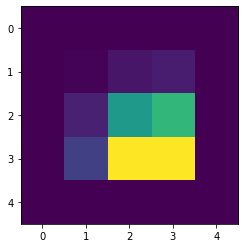

0.7092977942853952 0.7628020341654826


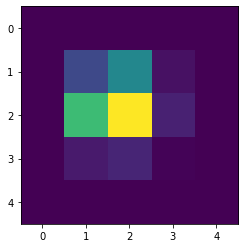

0.30839985371568124 0.3270686132144468


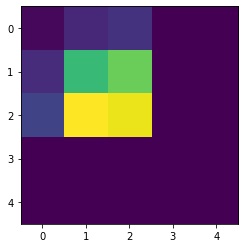

-0.16628214360300483 -0.21382789247922152


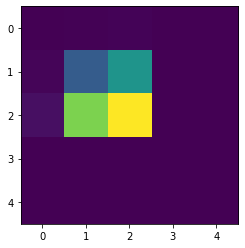

-0.01343296904100803 0.006945419478322208


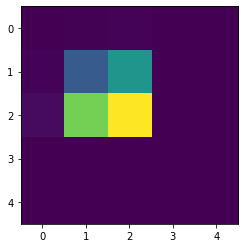

-0.005421479904375162 0.0009199634782222383


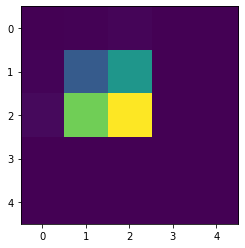

-0.0029597721402516756 -0.0007743409385624776


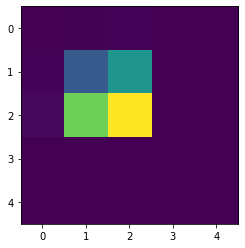

-0.0020396017505909564 -0.001129763347604703


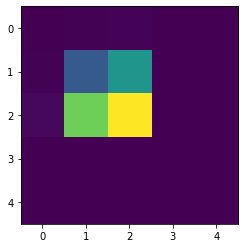

-0.0016046671417164705 -0.001113408441220948


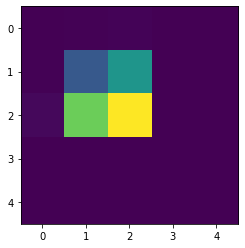

-0.001344944068673705 -0.0010093177319907493


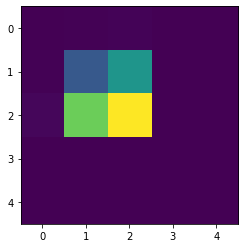

-0.0011616510624874652 -0.0008966666610385256


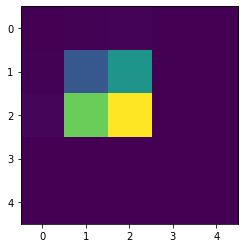

-0.0010196410301233799 -0.0007952080414160859


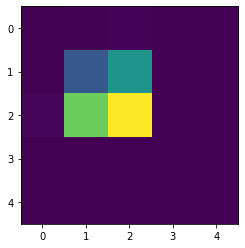

-0.0009042536120097355 -0.0007079690986437506


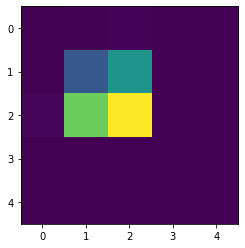

-0.0008080815864247203 -0.000633666059250466


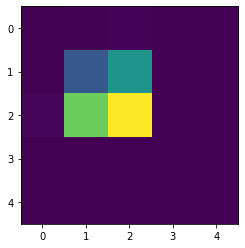

-0.0007266677000452234 -0.0005702340075377184


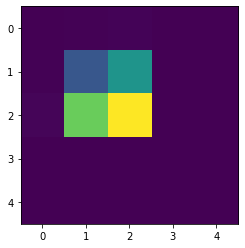

-0.000656980772753394 -0.0005157557312775906


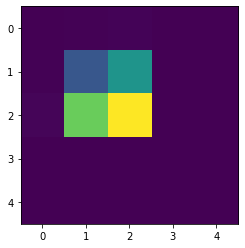

-0.0005968044364933835 -0.00046864455746804064


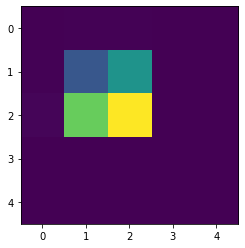

-0.0005444501380156944 -0.00042762825745024146


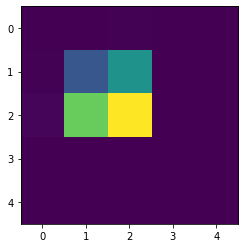

-0.000498599325261522 -0.0003916920111378082


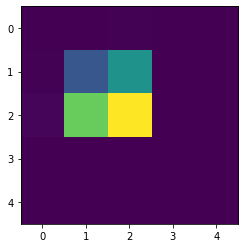

-0.0004582051429151326 -0.000360022901428213


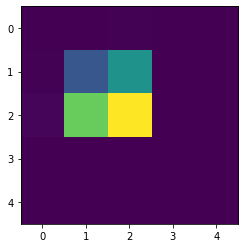

dx:  1.0174784306845497
dy:  1.013785463557352


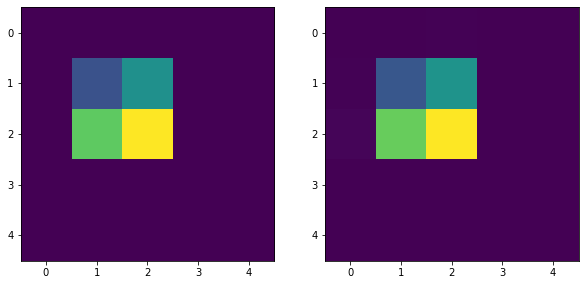

In [16]:
dx_sum = 0
dy_sum = 0
# pt = (2, 2)
# win_size = 5
# s = (win_size + 1) // 2
# x_min = np.clip(pt[0] - s, 0, img2.shape[1])
# x_max = np.clip(pt[0] + s, 0, img2.shape[1])
# y_min = np.clip(pt[1] - s, 0, img2.shape[0])
# y_max = np.clip(pt[1] + s, 0, img2.shape[0])
# img1_win, img2_win = select_win([img1, img2], slice(y_min, y_max), slice(x_min, x_max))
img1_win, img2_win = img1, img2
for i in range(20):
    dx, dy = optical_flow(img1_win, img2_win, 11, 1)
    print(dx, dy)
    dx_sum += dx
    dy_sum += dy
    img2_shift = get_new_img(img2, dx_sum, dy_sum)
    plt.imshow(img2_shift)
    plt.show()
    img2_win = img2_shift
    # img2_win = select_win([img2_shift], slice(y_min, y_max), slice(x_min, x_max))[0]
print('dx: ', dx_sum)
print('dy: ', dy_sum)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img1)
ax[1].imshow(img2_shift)
plt.show()

In [17]:
img1 = plt.imread('frame10.png')
img2 = plt.imread('frame11.png')

FileNotFoundError: [Errno 2] No such file or directory: 'frame10.png'

1.8327475879954946 -0.7086897889766388


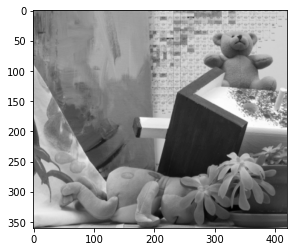

1.4190233445879221 0.5055539106350798


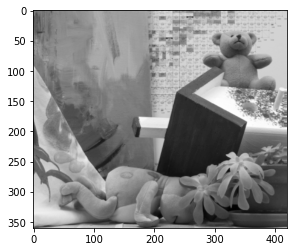

0.44590141966642705 0.5811371497468379


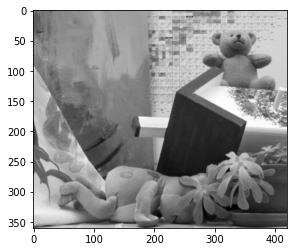

-0.06292605773822796 -0.09883841670738047


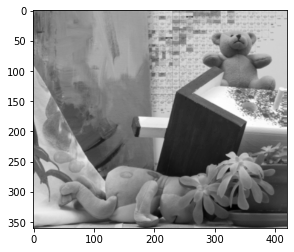

0.017257929221088257 0.04717754007494673


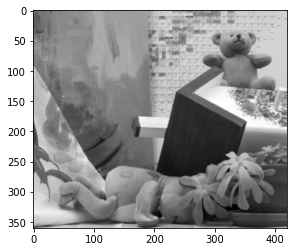

-0.0033401726989495933 -0.020854599481695792


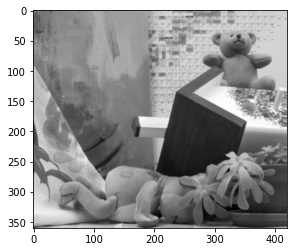

5.6662614802858045e-06 0.009896448034476023


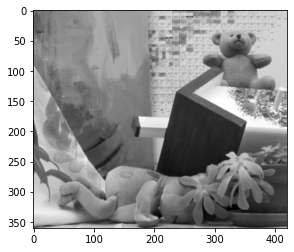

0.0005718037025103772 -0.004672442874199552


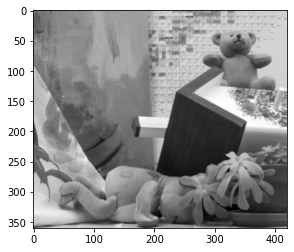

-0.00047291527376668957 0.002251187516982231


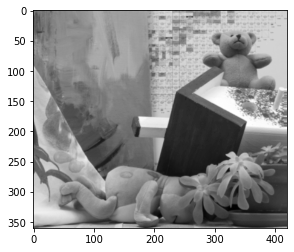

0.0002989249682687281 -0.0010885245231885433


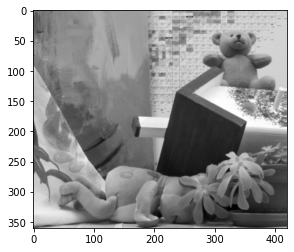

-0.0001695043745402135 0.0005304093298571888


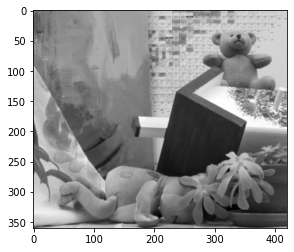

9.114827115921679e-05 -0.0002592261322018437


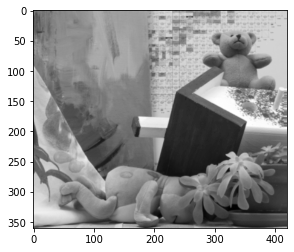

-4.7505969062270167e-05 0.00012710638858935236


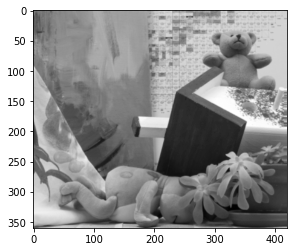

2.430077968941781e-05 -6.243028456244979e-05


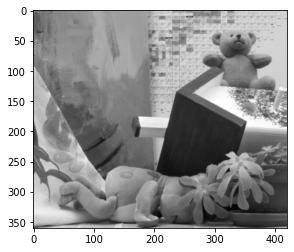

-1.2280834620263314e-05 3.0708474399159555e-05


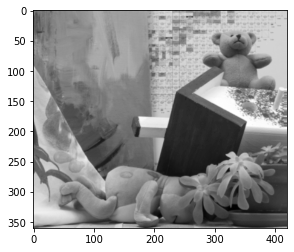

6.157940111643795e-06 -1.5118213407303452e-05


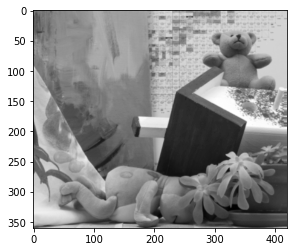

-3.0715915123856283e-06 7.4479023743779705e-06


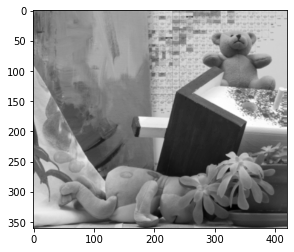

1.526756333027698e-06 -3.670741635810918e-06


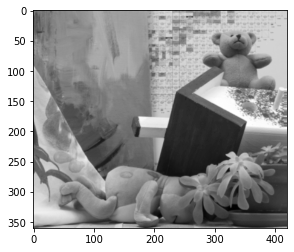

-7.570791786762674e-07 1.8097106183912477e-06


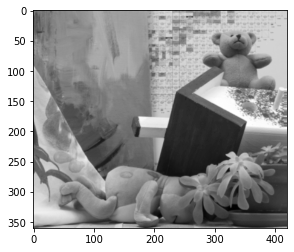

3.7481025882824204e-07 -8.923889742000151e-07


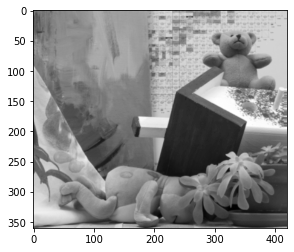

dx:  3.648957919400886
dy:  0.31222860749027653


In [11]:
# exp1: sigma = 3
# exp2: kernerl_size = 3
# exp3: win_size = 3
dx_sum = 0
dy_sum = 0
pt = (340, 45)
win_size = 15
s = (win_size + 1) // 2
img1_win, img2_win = select_win([img1, img2], slice(pt[1]-s, pt[1]+s), slice(pt[0]-s, pt[0]+s))
for i in range(20):
    dx, dy = optical_flow(img1_win, img2_win, 9, 1) 
    print(dx, dy)
    dx_sum += dx
    dy_sum += dy
    img2_shift = get_new_img(img2, dx_sum, dy_sum)
    plt.imshow(img2_shift, cmap='gray')
    plt.show()
    img2_win = select_win([img2_shift], slice(pt[1]-s, pt[1]+s), slice(pt[0]-s, pt[0]+s))[0]
print('dx: ', dx_sum)
print('dy: ', dy_sum)

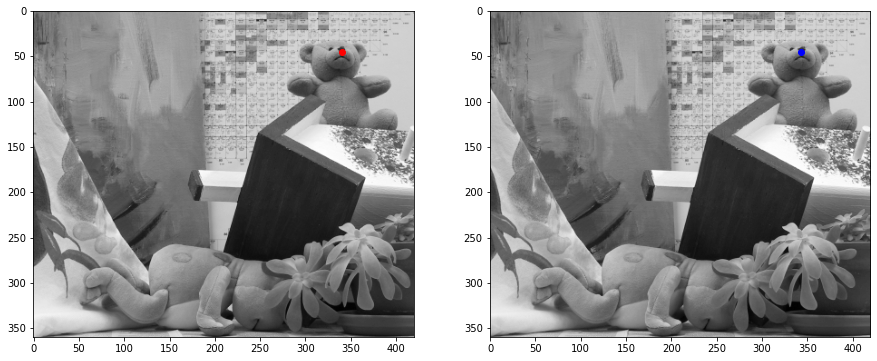

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(img1, cmap='gray')
ax[0].plot(pt[0], pt[1], 'ro')
ax[1].imshow(img2, cmap='gray')
ax[1].plot(pt[0]+dx_sum, pt[1]+dy_sum, 'bo')

## Affine motion model example


Affine motion model
$$\begin{bmatrix} x+u \\ y+v \end{bmatrix} = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}\begin{bmatrix} x \\y\end{bmatrix} +\begin{bmatrix} b_1 \\ b_2\end{bmatrix} $$ tells us 
$$u = (A_{11} - 1)x + A_{12} y +b_1$$
$$v = A_{21} x + (A_{22} - 1) y + b_2$$
We can plug them in the Taylor expansion $$J_x u + J_y v + I_t \approx 0$$ and get 
$$A =\begin{bmatrix}  J_x x & J_x y & J_x & J_y x & J_y y & J_y \end{bmatrix} $$ 
$$x = \begin{bmatrix} A_{11} - 1 \\ A_{12} \\ b_1 \\ A_{21} \\ A_{22} - 1 \\ b_2\end{bmatrix}$$
$$ b = -I_t $$
in the least squares $||Ax-b||^2$ setting.

Notice the origin of coordinates of affine motion model is at the image center.

## 2D simple example
$$\begin{bmatrix} x+u \\ y+v \end{bmatrix} =\begin{bmatrix} 2 & 0 \\ 0 & 2 \end{bmatrix}\begin{bmatrix} x \\ y \end{bmatrix} $$

In [13]:
# 2D example
img = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 1, 1, 0, 0, 0],
                [0, 0, 0, 1, 1, 1, 0, 0, 0],
                [0, 0, 0, 1, 1, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                ] )
img_next = np.array([
                     [0,   0,    0,   0,   0,   0,   0,   0,  0],
                     [0, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0],
                     [0, 0.5,   1,   1,    1,   1,   1, 0.5,  0],
                     [0, 0.5,   1,   1,    1,   1,   1, 0.5,  0],
                     [0, 0.5,   1,   1,    1,   1,   1, 0.5,  0],
                     [0, 0.5,   1,   1,    1,   1,   1, 0.5,  0],
                     [0, 0.5,   1,   1,    1,   1,   1, 0.5,  0],
                     [0, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0],
                     [0,   0,   0,   0,    0,   0,   0,   0,  0],
                     ] )

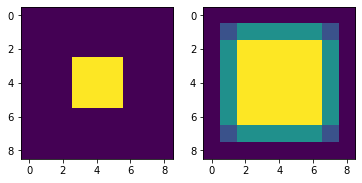

In [14]:
plt.subplot('121')
plt.imshow(img)
plt.subplot('122')
plt.imshow(img_next)

In [15]:
x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
x = x - img.shape[1] // 2
y = y - img.shape[0] // 2

In [16]:
x

array([[-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4]])

In [17]:
y

array([[-4, -4, -4, -4, -4, -4, -4, -4, -4],
       [-3, -3, -3, -3, -3, -3, -3, -3, -3],
       [-2, -2, -2, -2, -2, -2, -2, -2, -2],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4]])

In [18]:
fx = np.array([[1, 0, -1]])
fy = fx.T

# comment these two lines when using Gaussian blur
# Ix = convolve(img_next, fx, mode='same')
# Iy = convolve(img_next, fy, mode='same')

# uncomment following lines to use Gaussian blur 
G = cv2.getGaussianKernel(11, 30)
G = G @ G.T
Gx = convolve(G, fx, mode='same')
Gy = convolve(G, fy, mode='same')
Ix = convolve(img_next, Gx, mode='same')
Iy = convolve(img_next, Gy, mode='same')


It = img_next - img
A = np.c_[(Ix * x).ravel(), (Ix * y).ravel(), Ix.ravel(),
           (Iy * x).ravel(), (Iy * y).ravel(), Iy.ravel()]
b = (-It).ravel()

res = np.linalg.solve(A.T @ A, A.T @ b)

# recover coefficients
A_ = np.array([[res[0]+1, res[1]], [res[3], res[4]+1]])
b_ = np.array([res[2], res[5]])
print('A:', A_)
print('b:', b_)

A: [[ 2.00343030e+00 -1.81499335e-15]
 [ 1.73906427e-15  2.00343030e+00]]
b: [-6.03295215e-16 -3.29569297e-16]


## Optical flow with PyTorch
It is also possible to use gradient descent to solve the least squares problem. We can implement the algorithm in PyTorch to make use of its automatic differentiation ability.

In [19]:
img1 = np.array([[0., 0, 0, 0, 0],
                [0, 1, 2, 0, 0],
                [0, 3, 4, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0]]) 
img2 = np.array([[0., 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 1, 2, 0],
                [0, 0, 3, 4, 0],
                [0, 0, 0, 0, 0]])
Jx, Jy = findGradient(img2, 7, 1.3)
It = img2 - img1
A = np.hstack((Jx.reshape(-1, 1), Jy.reshape(-1, 1)))
b = -It.reshape(-1, 1)

## method 1: close form solution
# res = np.linalg.solve(A.T @ A, A.T @ b) 

## method 2: pytorch

### define a model

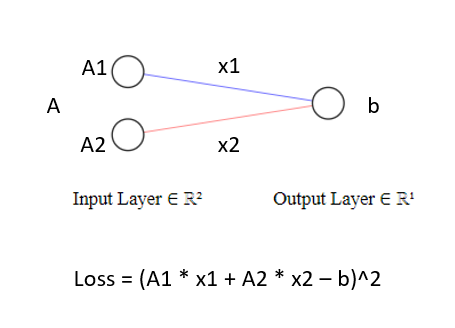

In [20]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(2, 1, bias=False)

    def forward(self, x):
        return self.fc(x)

### define dataset and dataloader
- Data: A (25 by 2)
- Parameters to estimate: x (2 by 1)
- Label: b (25 by 1)

In [21]:
class OptflowData(Dataset):
    def __init__(self, A, b):
        super().__init__()
        self.data = A
        self.label = b
  
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [22]:
model = Model()
dataset = OptflowData(A, b)
dataloader = DataLoader(dataset, batch_size=5)

### define loss function and optimizer

In [23]:
loss_fn = torch.nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=0.5)

### PyTorch training loop

In [24]:
epoch = 500
for i in range(epoch):
    loss_sum = 0
    for j, (x, y) in enumerate(dataloader):
        x, y = x.float(), y.float()
        y_pred = model(x)
        opt.zero_grad()
        loss = loss_fn(y_pred, y)
        loss.backward()
        loss_sum += loss.item()
        opt.step()
    print('epoch {}: {}'.format(i, loss_sum / j))

epoch 0: 2.6167331589322202
epoch 1: 2.6050033607916703
epoch 2: 2.5962143009965075
epoch 3: 2.5896044253495347
epoch 4: 2.5846141429501586
epoch 5: 2.5808294582602684
epoch 6: 2.5779462417049217
epoch 7: 2.575738349092717
epoch 8: 2.574038257705979
epoch 9: 2.572722016571788
epoch 10: 2.5716968137130607
epoch 11: 2.5708934613794554
epoch 12: 2.5702599626674782
epoch 13: 2.569757413919433
epoch 14: 2.5693563360982807
epoch 15: 2.56903409709048
epoch 16: 2.5687736634281464
epoch 17: 2.5685625098994933
epoch 18: 2.568390001077205
epoch 19: 2.5682483006094117
epoch 20: 2.5681316964910366
epoch 21: 2.5680350584589178
epoch 22: 2.567954768514028
epoch 23: 2.567887922661612
epoch 24: 2.567831868698704
epoch 25: 2.5677851202199236
epoch 26: 2.567745888401987
epoch 27: 2.567712385833147
epoch 28: 2.5676843200053554
epoch 29: 2.567660809334484
epoch 30: 2.567640525987372
epoch 31: 2.5676235192950116
epoch 32: 2.567608987519634
epoch 33: 2.5675969413423445
epoch 34: 2.5675865825032815
epoch 35: 

In [25]:
w = model.fc.weight.detach().numpy()

In [26]:
np.square(A@w.T - b).sum()

50.45524204118263

In [27]:
# close form solution
res = np.linalg.solve(A.T @ A, A.T @ b) 
np.square(A@res - b).sum()

50.437634338949366